In [1]:
!pip install qiskit qiskit-aer matplotlib pandas numpy tensorflow pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 138.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 159.0 MB/s eta 0:00:00


# Stock Price Prediction with Quantum-Enhanced LSTM and QGAF

This notebook presents a sophisticated approach to predicting stock prices, specifically the 'Close' price, by integrating classical Long Short-Term Memory (LSTM) networks with a novel Quantum Layer. The data is preprocessed using a variety of financial indicators and then fed into a dual-head model. A key innovation here is the use of a quantum-enhanced layer (though in the provided code, QGAF itself isn't explicitly implemented, the `QLayer` serves as a quantum-inspired enhancement). The model predicts the normalized return, `(Close - Open) / Open`, and then reconstructs the 'Close' price, ensuring it's clamped within the actual 'Low' and 'High' bounds of the day.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import pennylane as qml
import os

In [ ]:
TRAIN_PATH = "X_train.csv"
TEST_PATH  = "X_test.csv"
OUT_PATH   = "predictions.csv"

In [ ]:
def load_data(train_path=TRAIN_PATH, test_path=TEST_PATH):
    """
    Loads training and testing data from CSV files, converts 'Date' column to datetime,
    and sorts the data by date.

    Args:
        train_path (str): Path to the training CSV file.
        test_path (str): Path to the testing CSV file.

    Returns:
        tuple: A tuple containing two pandas DataFrames: train_df and test_df.
    """
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)
    for df in (train_df, test_df):
        df["Date"] = pd.to_datetime(df["Date"])
        df.sort_values("Date", inplace=True)
        df.reset_index(drop=True, inplace=True)
    return train_df, test_df

### Technical Indicators and Lagged Features:

- **High_Low**: Absolute difference between High and Low price.
- **LogVolume**: Log-transformed trading volume, which can help normalize skewed volume data.
- **Day of Week (DOW_sin, DOW_cos)**: Sinusoidal and cosinusoidal transformations of the day of the week to capture weekly seasonality.
- **Returns (ret_5, ret_10)**: Log returns over 5 and 10 periods, indicating past price changes.
- **Volatility (vol_5, vol_10)**: Standard deviation of log returns over 5 and 10 periods, measuring price fluctuation.
- **EMA Gap (ema_gap)**: Difference between a fast and slow Exponential Moving Average (EMA), indicating momentum.
- **Volume Z-score (vol_zscore)**: Z-score of volume relative to its 20-period mean and standard deviation, highlighting unusual volume activity.
- **Month (month_sin, month_cos)**: Sinusoidal and cosinusoidal transformations of the month to capture annual seasonality.
- **Average True Range (atr14)**: A measure of market volatility over 14 periods.
- **Drawdown (drawdown_60)**: Percentage drop from the 60-period rolling maximum, indicating how far the price has fallen from a recent peak.
- **Simple Moving Averages (SMA_5_lag1, SMA_10_lag1, SMA_20_lag1)**: Lagged Simple Moving Averages over various windows.
- **Relative Strength Index (RSI_14_lag1)**: Lagged RSI over 14 periods, a momentum oscillator.
- **Close_lag1, Close_lag2**: Lagged closing prices from the previous one and two days, providing direct historical price context.

### Target Variable Creation:

The primary target variable is `r_norm = (Close - Open) / Open`, which represents the normalized return for the *next* day. This is shifted to ensure that features at time `t` are used to predict the return at time `t+1`.

Additionally, two auxiliary target variables are created for the dual-head model:
- `sign`: Binary indicator (1 if `r_norm > 0`, 0 otherwise) for directional prediction.
- `mag`: Absolute value of `r_norm`, clipped to `[0, 1]` for magnitude prediction.

In [ ]:
def calculate_rsi(series, window=14):
    """
    Calculates the Relative Strength Index (RSI) for a given series.

    Args:
        series (pd.Series): The input price series (e.g., Close prices).
        window (int): The lookback window for RSI calculation.

    Returns:
        pd.Series: The RSI values.
    """
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=window, min_periods=window).mean()
    loss = (-delta.clip(upper=0)).rolling(window=window, min_periods=window).mean().replace(0, 1e-6)
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def build_feature_frames(train_df, test_df, lookback=60, rsi_window=14, sma_windows=(5,10,20)):
    """
    Engineers features and target variables for stock price prediction.

    Args:
        train_df (pd.DataFrame): Training DataFrame.
        test_df (pd.DataFrame): Testing DataFrame.
        lookback (int): The lookback window for sequence creation.
        rsi_window (int): Window for RSI calculation.
        sma_windows (tuple): Tuple of windows for SMA calculation.

    Returns:
        tuple: A tuple containing:
            - X_train (np.array): Scaled training features.
            - y_cls (np.array): Training labels for classification (direction).
            - y_reg (np.array): Training labels for regression (magnitude).
            - y_rnorm_full (np.array): Full normalized return for training.
            - X_test_raw (pd.DataFrame): Raw test features.
            - feat_scaler (StandardScaler): Fitted feature scaler.
            - feats (list): List of feature names.
            - train_eng (pd.DataFrame): Engineered training DataFrame.
            - test_eng (pd.DataFrame): Engineered testing DataFrame.
    """
    # Append test with Close as NaN to avoid leakage in target construction
    combined = pd.concat(
        [train_df.copy(), test_df.copy().assign(Close=np.nan)],
        ignore_index=True
    ).sort_values("Date").reset_index(drop=True)

    combined["High_Low"]  = (combined["High"] - combined["Low"]).abs()
    combined["LogVolume"] = np.log1p(combined["Volume"])

    dow = combined["Date"].dt.dayofweek.astype(float)
    combined["DOW_sin"] = np.sin(2*np.pi*dow/7.0)
    combined["DOW_cos"] = np.cos(2*np.pi*dow/7.0)

    # Returns and vols based on Close where available
    r1 = np.log(combined["Close"] / combined["Close"].shift(1))
    combined["ret_5"]  = r1.rolling(5).sum().shift(1)
    combined["ret_10"] = r1.rolling(10).sum().shift(1)
    combined["vol_5"]  = r1.rolling(5).std().shift(1)
    combined["vol_10"] = r1.rolling(10).std().shift(1)

    ema_fast = combined["Close"].ewm(span=5, adjust=False).mean()
    ema_slow = combined["Close"].ewm(span=20, adjust=False).mean()
    combined["ema_gap"] = ((ema_fast - ema_slow) / ema_slow).shift(1)

    vmean20 = combined["Volume"].rolling(20, min_periods=20).mean()
    vstd20  = combined["Volume"].rolling(20, min_periods=20).std()
    combined["vol_zscore"] = ((combined["Volume"] - vmean20) / (vstd20.replace(0, np.nan))).shift(1)

    combined["month_sin"] = np.sin(2*np.pi*combined["Date"].dt.month/12.0)
    combined["month_cos"] = np.cos(2*np.pi*combined["Date"].dt.month/12.0)

    tr = (combined["High"] - combined["Low"]).abs()
    combined["atr14"] = tr.rolling(14, min_periods=14).mean().shift(1)

    roll_max_60 = combined["Close"].shift(1).rolling(60, min_periods=60).max()
    combined["drawdown_60"] = (combined["Close"].shift(1) / roll_max_60 - 1.0)

    for w in sma_windows:
        combined[f"SMA_{w}_lag1"] = combined["Close"].rolling(w, min_periods=w).mean().shift(1)
    combined[f"RSI_{rsi_window}_lag1"] = calculate_rsi(combined["Close"], rsi_window).shift(1)

    combined["Close_lag1"] = combined["Close"].shift(1)
    combined["Close_lag2"] = combined["Close"].shift(2)

    # Split engineered frame back into train and test views
    max_train_date = train_df["Date"].max()
    train_eng = combined[combined["Date"] <= max_train_date].copy()
    test_eng  = combined[combined["Date"] >  max_train_date].copy()

    # Fill feature NaNs using only historical info per split
    for df in (train_eng, test_eng):
        df.ffill(inplace=True)
        df.bfill(inplace=True)

    base = ["Open","High","Low","Volume"]
    feats = base + [
        "High_Low","LogVolume","DOW_sin","DOW_cos",
        "Close_lag1","Close_lag2",
        "ret_5","ret_10","vol_5","vol_10","ema_gap","vol_zscore",
        "month_sin","month_cos","atr14","drawdown_60",
        f"RSI_{rsi_window}_lag1"
    ] + [f"SMA_{w}_lag1" for w in sma_windows]

    # Target on train: r_norm = (Close - Open)/Open for next day
    # Shift so features at t predict r_norm at t
    r_norm = (train_df["Close"] - train_df["Open"]) / train_df["Open"]
    r_norm = r_norm.shift(-1).reindex(train_eng.index)  # align to train_eng rows
    train_eng["r_norm"] = r_norm

    train_eng["sign"] = (train_eng["r_norm"] > 0).astype(np.float32)
    train_eng["mag"]  = train_eng["r_norm"].abs().clip(0, 1.0)  # safe clip

    train_eng = train_eng.dropna(subset=["r_norm", "sign", "mag"])

    X_train_raw = train_eng[feats].values.astype(np.float32)
    y_cls = train_eng["sign"].values.reshape(-1,1).astype(np.float32)
    y_reg = train_eng["mag"].values.reshape(-1,1).astype(np.float32)
    y_rnorm_full = train_eng["r_norm"].values.astype(np.float32).reshape(-1,1)

    feat_scaler = StandardScaler()
    X_train = feat_scaler.fit_transform(X_train_raw).astype(np.float32)

    X_test_raw = test_eng[feats].copy().reset_index(drop=True)

    return (X_train, y_cls, y_reg, y_rnorm_full,
            X_test_raw, feat_scaler, feats, train_eng, test_eng)

## 5. Quantum Layer Implementation

### Key Components:

- **`n_qubits`**: The number of qubits in the quantum circuit. This also corresponds to the input size for the quantum layer.
- **`n_layers`**: The number of "strongly entangling layers" in the quantum circuit. More layers allow for more complex transformations.
- **`qml.device("default.qubit", wires=n_qubits)`**: Initializes a quantum simulator device from PennyLane.
- **`circuit`**: The quantum circuit itself.
    - `qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")`: Encodes the classical input features into the quantum state by applying Y-rotations to each qubit.
    - `qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))`: Applies a series of entangling and rotational gates, parameterized by `weights`. This is a common Ansatz for variational quantum circuits.
    - `qml.expval(qml.PauliZ(0))`: Measures the expectation value of the Pauli-Z operator on the first qubit. This acts as the output of the quantum layer.
- **`self.theta`**: Trainable weights for the `StronglyEntanglingLayers`. These weights are optimized during the model's training process, similar to classical neural network weights.
- **`call(self, inputs)`**: This method defines the forward pass of the custom Keras layer. It takes the classical inputs, passes them to the quantum circuit (via `tf.vectorized_map` for batch processing), and returns the quantum output.

While the original problem description mentions "Quantum Gramian Angular Fields (QGAF)", the provided `QLayer` directly uses `AngleEmbedding` and `StronglyEntanglingLayers`. QGAF is an encoding technique, and this `QLayer` can be seen as a quantum-enhanced feature extractor within the hybrid model.

In [ ]:
class QLayer(tf.keras.layers.Layer):
    """
    A custom Keras layer that integrates a PennyLane quantum circuit.

    Args:
        n_qubits (int): Number of qubits in the quantum circuit.
        n_layers (int): Number of strongly entangling layers in the circuit.
        name (str): Name of the layer.
        **kwargs: Additional keyword arguments for the Keras Layer.
    """
    def __init__(self, n_qubits=4, n_layers=2, name="quantum_layer", **kwargs):
        super().__init__(name=name, dtype=tf.float32, **kwargs)
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="tf", diff_method="parameter-shift")
        def circuit(inputs, weights):
            """
            The quantum circuit architecture.
            Inputs are embedded using AngleEmbedding, followed by strongly entangling layers.
            The expectation value of PauliZ on the first qubit is returned.
            """
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
            qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
            return qml.expval(qml.PauliZ(0))
        self.qnode = circuit

        # Trainable weights for the strongly entangling layers
        self.theta = self.add_weight(
            name="weights", shape=(n_layers, n_qubits, 3), # 3 parameters per CNOT-Ry-Rz block
            initializer=tf.keras.initializers.RandomUniform(0.0, 2.0*np.pi),
            trainable=True, dtype=tf.float32
        )

    def call(self, inputs):
        """
        Forward pass for the QLayer.
        """
        x = tf.cast(inputs, tf.float32)
        w = tf.cast(self.theta, tf.float32)
        # Apply the quantum circuit to each item in the batch
        out = tf.vectorized_map(lambda v: self.qnode(v, w), x)  # (batch,)
        return tf.reshape(out, (-1,1)) # Reshape to (batch_size, 1)

## 6. Dual-Head Model Architecture

The `build_dual_head_model` function constructs the hybrid neural network. This model is designed with a "dual-head" approach, meaning it has two distinct output layers to predict different aspects of the target:
1.  **Classification Head (`cls_out`)**: Predicts the direction of the price movement (up or down).
2.  **Regression Head (`reg_out`)**: Predicts the magnitude of the price movement.

### Model Flow:

1.  **Input Layer**: Takes sequences of features with a defined `lookback` window.
2.  **LSTM Layers**: Two LSTM layers process the sequential input data. LSTMs are well-suited for time series as they can learn long-term dependencies. `return_sequences=True` for the first LSTM means it outputs a sequence, while `return_sequences=False` for the second means it outputs a single vector representing the entire sequence. L2 regularization is applied to prevent overfitting.
3.  **Trunk Dense Layer**: A `Dense` layer with ReLU activation acts as a feature extractor from the LSTM output.
4.  **Quantum Branch**:
    -   A `Dense` layer reduces the dimensionality of the `trunk` output to match the number of qubits (`n_qubits`), and applies a `tanh` activation to scale the inputs to the quantum layer.
    -   The `QLayer` (our custom quantum-enhanced layer) processes these inputs.
5.  **Concatenation**: The output of the `trunk` and the `QLayer` are concatenated, combining classical and quantum features.
6.  **Classification Head**:
    -   A `Dense` layer with ReLU activation processes the concatenated features.
    -   A `Dropout` layer helps prevent overfitting.
    -   The final `Dense` layer with `sigmoid` activation outputs a probability (for 'up' movement). `name="cls_out"` identifies this output.
7.  **Regression Head**:
    -   Another `Dense` layer with ReLU activation processes the concatenated features.
    -   The final `Dense` layer with `relu` activation outputs the magnitude of the normalized return. `name="reg_out"` identifies this output.

### Loss Functions and Optimizer:

-   **`cls_out` Loss**: `BinaryCrossentropy` is used, suitable for binary classification (up/down).
-   **`reg_out` Loss**: `Huber` loss is used, which is less sensitive to outliers than Mean Squared Error (MSE), making it suitable for regression tasks in financial data.
-   **Loss Weights**: Both losses are weighted equally (1.0).
-   **Optimizer**: Adam optimizer is used, a popular choice for deep learning, with a learning rate of `1e-3`.
-   **Metrics**: Accuracy and AUC for classification, and Mean Absolute Error (MAE) for regression, are monitored.

In [ ]:
def build_dual_head_model(lookback, n_features, n_qubits=4, n_layers=2, l2=1e-3, drop_cls=0.3):
    """
    Builds a dual-head hybrid LSTM + Quantum model for stock price prediction.

    Args:
        lookback (int): The number of past time steps to consider.
        n_features (int): The number of features per time step.
        n_qubits (int): Number of qubits for the quantum layer.
        n_layers (int): Number of layers in the quantum circuit.
        l2 (float): L2 regularization strength.
        drop_cls (float): Dropout rate for the classification head.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    inp = layers.Input(shape=(lookback, n_features))
    # LSTM layers for sequence processing
    x = layers.LSTM(64, return_sequences=True,
                    kernel_regularizer=regularizers.l2(l2),
                    recurrent_regularizer=regularizers.l2(l2))(inp)
    x = layers.LSTM(32, return_sequences=False, # Last LSTM output a single vector
                    kernel_regularizer=regularizers.l2(l2),
                    recurrent_regularizer=regularizers.l2(l2))(x)
    trunk = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)

    # Quantum branch
    q_inp = layers.Dense(n_qubits, activation="tanh", kernel_regularizer=regularizers.l2(l2))(trunk)
    q_out = QLayer(n_qubits=n_qubits, n_layers=n_layers)(q_inp) # Our custom quantum layer
    shared = layers.Concatenate()([trunk, q_out]) # Combine classical and quantum features

    # Classification head (for direction prediction)
    h1 = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2))(shared)
    h1 = layers.Dropout(drop_cls)(h1)
    cls_out = layers.Dense(1, activation="sigmoid", name="cls_out")(h1) # Sigmoid for binary classification

    # Regression head (for magnitude prediction)
    h2 = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2))(shared)
    reg_out = layers.Dense(1, activation="relu", name="reg_out")(h2) # ReLU for positive magnitude

    model = models.Model(inp, outputs=[cls_out, reg_out])
    losses = {"cls_out": tf.keras.losses.BinaryCrossentropy(from_logits=False),
              "reg_out": tf.keras.losses.Huber(delta=0.5)} # Huber loss is less sensitive to outliers
    loss_weights = {"cls_out": 1.0, "reg_out": 1.0} # Equal weighting for both losses

    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"cls_out": [tf.keras.metrics.BinaryAccuracy(name="acc"), tf.keras.metrics.AUC(name="auc")],
                 "reg_out": [tf.keras.metrics.MeanAbsoluteError(name="mae")]}
    )
    return model

In [ ]:
def create_dual_sequences(X, y_cls, y_reg, y_rnorm, lookback):
    """
    Creates sequences of features and corresponding dual targets for LSTM input.

    Args:
        X (np.array): Features array.
        y_cls (np.array): Classification targets.
        y_reg (np.array): Regression targets.
        y_rnorm (np.array): Full normalized return targets.
        lookback (int): The number of past time steps to include in each sequence.

    Returns:
        tuple: A tuple containing:
            - Xs (np.array): 3D array of feature sequences.
            - Y_dict (dict): Dictionary of dual targets (classification and regression).
            - yN (np.array): Full normalized return sequences.
    """
    Xs, y1, y2, yN = [], [], [], []
    N = len(X)
    for i in range(N - lookback):
        j = i + lookback
        Xs.append(X[i:j]) # Features from i to j-1
        y1.append(y_cls[j]) # Target at j
        y2.append(y_reg[j]) # Target at j
        yN.append(y_rnorm[j]) # Target at j
    if not Xs: # Handle cases where sequences cannot be formed (e.g., data too short)
        emptyX = np.empty((0, lookback, X.shape[1]), np.float32)
        empty1 = np.empty((0, 1), np.float32)
        return emptyX, {"cls_out": empty1, "reg_out": empty1}, empty1
    return (np.asarray(Xs, np.float32),
            {"cls_out": np.asarray(y1, np.float32),
             "reg_out": np.asarray(y2, np.float32)},
            np.asarray(yN, np.float32))

def time_split_dual(X, y_cls, y_reg, y_rnorm, lookback, split=0.8):
    """
    Splits the data into training and validation sets chronologically.

    Args:
        X (np.array): Features array.
        y_cls (np.array): Classification targets.
        y_reg (np.array): Regression targets.
        y_rnorm (np.array): Full normalized return targets.
        lookback (int): The lookback window for sequence creation.
        split (float): Proportion of data to use for training (e.g., 0.8 for 80%).

    Returns:
        tuple: A tuple containing (training sequences, validation sequences).
    """
    n = len(X); k = int(split * n)
    return (
        create_dual_sequences(X[:k], y_cls[:k], y_reg[:k], y_rnorm[:k], lookback),
        create_dual_sequences(X[k:],  y_cls[k:],  y_reg[k:],  y_rnorm[k:],  lookback),
    )

In [ ]:
def fit_dual(model, X_tr_seq, Y_tr, X_va_seq, Y_va, epochs=120, batch=32):
    """
    Trains the dual-head model with early stopping and learning rate reduction.

    Args:
        model (tf.keras.Model): The compiled Keras model.
        X_tr_seq (np.array): Training feature sequences.
        Y_tr (dict): Training targets for classification and regression.
        X_va_seq (np.array): Validation feature sequences.
        Y_va (dict): Validation targets for classification and regression.
        epochs (int): Maximum number of training epochs.
        batch (int): Batch size for training.
    """
    es  = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    model.fit(
        X_tr_seq, Y_tr,
        validation_data=(X_va_seq, Y_va) if len(X_va_seq) else None, # Only use validation if available
        epochs=epochs, batch_size=batch, verbose=1, callbacks=[es, rlr]
    )

def sequence_return_metrics(model, X_seq, y_norm_seq):
    """
    Calculates MSE and R-squared for the full normalized return (r_norm) on sequences.

    Args:
        model (tf.keras.Model): The trained Keras model.
        X_seq (np.array): Feature sequences.
        y_norm_seq (np.array): True normalized return sequences.

    Returns:
        tuple: (MSE, R-squared, predicted r_norm)
    """
    if len(X_seq) == 0:
        return None, None, None
    p_up, mag = model.predict(X_seq, verbose=0)
    # Reconstruct r_norm prediction from directional probability and magnitude
    r_norm_pred = (2.0 * p_up - 1.0) * mag
    mse = mean_squared_error(y_norm_seq, r_norm_pred)
    r2  = r2_score(y_norm_seq, r_norm_pred)
    return mse, r2, r_norm_pred

In [6]:
# -*- coding: utf-8 -*-
"""
Dual-head Hybrid LSTM + Quantum (TensorFlow/PennyLane) predicting normalized return r_norm = (Close - Open)/Open.
Then reconstructs Close for the test set and clamps each prediction to [Low, High].

- Two heads:
    * cls_out: direction, BCE loss on 1{r_norm > 0}
    * reg_out: magnitude, Huber loss on |r_norm|
- Reports Train/Val MSE on r_norm.
- Writes predictions.csv with {Date, Close}. Plots predicted Close and High–Low band.

Inputs: X_train.csv, X_test.csv with columns: Date, Open, High, Low, Close, Volume
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
import pennylane as qml
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import argparse, warnings, matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

TRAIN_PATH = "X_train.csv"
TEST_PATH  = "X_test.csv"
OUT_PATH   = "predictions.csv"

# ============ IO ============
def load_data(train_path=TRAIN_PATH, test_path=TEST_PATH):
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)
    for df in (train_df, test_df):
        df["Date"] = pd.to_datetime(df["Date"])
        df.sort_values("Date", inplace=True)
        df.reset_index(drop=True, inplace=True)
    return train_df, test_df

# ============ Indicators ============
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=window, min_periods=window).mean()
    loss = (-delta.clip(upper=0)).rolling(window=window, min_periods=window).mean().replace(0, 1e-6)
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# ============ Features + Targets ============
def build_feature_frames(train_df, test_df, lookback=60, rsi_window=14, sma_windows=(5,10,20)):
    # Append test with Close as NaN to avoid leakage in target construction
    combined = pd.concat(
        [train_df.copy(), test_df.copy().assign(Close=np.nan)],
        ignore_index=True
    ).sort_values("Date").reset_index(drop=True)

    combined["High_Low"]  = (combined["High"] - combined["Low"]).abs()
    combined["LogVolume"] = np.log1p(combined["Volume"])

    dow = combined["Date"].dt.dayofweek.astype(float)
    combined["DOW_sin"] = np.sin(2*np.pi*dow/7.0)
    combined["DOW_cos"] = np.cos(2*np.pi*dow/7.0)

    # Returns and vols based on Close where available
    r1 = np.log(combined["Close"] / combined["Close"].shift(1))
    combined["ret_5"]  = r1.rolling(5).sum().shift(1)
    combined["ret_10"] = r1.rolling(10).sum().shift(1)
    combined["vol_5"]  = r1.rolling(5).std().shift(1)
    combined["vol_10"] = r1.rolling(10).std().shift(1)

    ema_fast = combined["Close"].ewm(span=5, adjust=False).mean()
    ema_slow = combined["Close"].ewm(span=20, adjust=False).mean()
    combined["ema_gap"] = ((ema_fast - ema_slow) / ema_slow).shift(1)

    vmean20 = combined["Volume"].rolling(20, min_periods=20).mean()
    vstd20  = combined["Volume"].rolling(20, min_periods=20).std()
    combined["vol_zscore"] = ((combined["Volume"] - vmean20) / (vstd20.replace(0, np.nan))).shift(1)

    combined["month_sin"] = np.sin(2*np.pi*combined["Date"].dt.month/12.0)
    combined["month_cos"] = np.cos(2*np.pi*combined["Date"].dt.month/12.0)

    tr = (combined["High"] - combined["Low"]).abs()
    combined["atr14"] = tr.rolling(14, min_periods=14).mean().shift(1)

    roll_max_60 = combined["Close"].shift(1).rolling(60, min_periods=60).max()
    combined["drawdown_60"] = (combined["Close"].shift(1) / roll_max_60 - 1.0)

    for w in sma_windows:
        combined[f"SMA_{w}_lag1"] = combined["Close"].rolling(w, min_periods=w).mean().shift(1)
    combined[f"RSI_{rsi_window}_lag1"] = calculate_rsi(combined["Close"], rsi_window).shift(1)

    combined["Close_lag1"] = combined["Close"].shift(1)
    combined["Close_lag2"] = combined["Close"].shift(2)

    # Split engineered frame back into train and test views
    max_train_date = train_df["Date"].max()
    train_eng = combined[combined["Date"] <= max_train_date].copy()
    test_eng  = combined[combined["Date"] >  max_train_date].copy()

    # Fill feature NaNs using only historical info per split
    for df in (train_eng, test_eng):
        df.ffill(inplace=True)
        df.bfill(inplace=True)

    base = ["Open","High","Low","Volume"]
    feats = base + [
        "High_Low","LogVolume","DOW_sin","DOW_cos",
        "Close_lag1","Close_lag2",
        "ret_5","ret_10","vol_5","vol_10","ema_gap","vol_zscore",
        "month_sin","month_cos","atr14","drawdown_60",
        f"RSI_{rsi_window}_lag1"
    ] + [f"SMA_{w}_lag1" for w in sma_windows]

    # Target on train: r_norm = (Close - Open)/Open for next day
    # Shift so features at t predict r_norm at t
    r_norm = (train_df["Close"] - train_df["Open"]) / train_df["Open"]
    r_norm = r_norm.shift(-1).reindex(train_eng.index)  # align to train_eng rows
    train_eng["r_norm"] = r_norm

    train_eng["sign"] = (train_eng["r_norm"] > 0).astype(np.float32)
    train_eng["mag"]  = train_eng["r_norm"].abs().clip(0, 1.0)  # safe clip

    train_eng = train_eng.dropna(subset=["r_norm", "sign", "mag"])

    X_train_raw = train_eng[feats].values.astype(np.float32)
    y_cls = train_eng["sign"].values.reshape(-1,1).astype(np.float32)
    y_reg = train_eng["mag"].values.reshape(-1,1).astype(np.float32)
    y_rnorm_full = train_eng["r_norm"].values.astype(np.float32).reshape(-1,1)

    feat_scaler = StandardScaler()
    X_train = feat_scaler.fit_transform(X_train_raw).astype(np.float32)

    X_test_raw = test_eng[feats].copy().reset_index(drop=True)

    return (X_train, y_cls, y_reg, y_rnorm_full,
            X_test_raw, feat_scaler, feats, train_eng, test_eng)

# ============ Quantum layer (TF-only) ============
class QLayer(tf.keras.layers.Layer):
    def __init__(self, n_qubits=4, n_layers=2, name="quantum_layer", **kwargs):
        super().__init__(name=name, dtype=tf.float32, **kwargs)
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="tf", diff_method="parameter-shift")
        def circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
            qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
            return qml.expval(qml.PauliZ(0))
        self.qnode = circuit

        self.theta = self.add_weight(
            name="weights", shape=(n_layers, n_qubits, 3),
            initializer=tf.keras.initializers.RandomUniform(0.0, 2.0*np.pi),
            trainable=True, dtype=tf.float32
        )

    def call(self, inputs):
        x = tf.cast(inputs, tf.float32)
        w = tf.cast(self.theta, tf.float32)
        out = tf.vectorized_map(lambda v: self.qnode(v, w), x)  # (batch,)
        return tf.reshape(out, (-1,1))

# ============ Dual-head model ============
def build_dual_head_model(lookback, n_features, n_qubits=4, n_layers=2, l2=1e-3, drop_cls=0.3):
    inp = layers.Input(shape=(lookback, n_features))
    x = layers.LSTM(64, return_sequences=True,
                    kernel_regularizer=regularizers.l2(l2),
                    recurrent_regularizer=regularizers.l2(l2))(inp)
    x = layers.LSTM(32, return_sequences=False,
                    kernel_regularizer=regularizers.l2(l2),
                    recurrent_regularizer=regularizers.l2(l2))(x)
    trunk = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)

    q_inp = layers.Dense(n_qubits, activation="tanh", kernel_regularizer=regularizers.l2(l2))(trunk)
    q_out = QLayer(n_qubits=n_qubits, n_layers=n_layers)(q_inp)
    shared = layers.Concatenate()([trunk, q_out])

    h1 = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2))(shared)
    h1 = layers.Dropout(drop_cls)(h1)
    cls_out = layers.Dense(1, activation="sigmoid", name="cls_out")(h1)

    h2 = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2))(shared)
    reg_out = layers.Dense(1, activation="relu", name="reg_out")(h2)

    model = models.Model(inp, outputs=[cls_out, reg_out])
    losses = {"cls_out": tf.keras.losses.BinaryCrossentropy(from_logits=False),
              "reg_out": tf.keras.losses.Huber(delta=0.5)}
    loss_weights = {"cls_out": 1.0, "reg_out": 1.0}

    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"cls_out": [tf.keras.metrics.BinaryAccuracy(name="acc"), tf.keras.metrics.AUC(name="auc")],
                 "reg_out": [tf.keras.metrics.MeanAbsoluteError(name="mae")]}
    )
    return model

# ============ Sequencing ============
def create_dual_sequences(X, y_cls, y_reg, y_rnorm, lookback):
    Xs, y1, y2, yN = [], [], [], []
    N = len(X)
    for i in range(N - lookback):
        j = i + lookback
        Xs.append(X[i:j])
        y1.append(y_cls[j])
        y2.append(y_reg[j])
        yN.append(y_rnorm[j])
    if not Xs:
        emptyX = np.empty((0, lookback, X.shape[1]), np.float32)
        empty1 = np.empty((0, 1), np.float32)
        return emptyX, {"cls_out": empty1, "reg_out": empty1}, empty1
    return (np.asarray(Xs, np.float32),
            {"cls_out": np.asarray(y1, np.float32),
             "reg_out": np.asarray(y2, np.float32)},
            np.asarray(yN, np.float32))

def time_split_dual(X, y_cls, y_reg, y_rnorm, lookback, split=0.8):
    n = len(X); k = int(split * n)
    return (
        create_dual_sequences(X[:k], y_cls[:k], y_reg[:k], y_rnorm[:k], lookback),
        create_dual_sequences(X[k:],  y_cls[k:],  y_reg[k:],  y_rnorm[k:],  lookback),
    )

# ============ Training ============
def fit_dual(model, X_tr_seq, Y_tr, X_va_seq, Y_va, epochs=120, batch=32):
    es  = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    model.fit(
        X_tr_seq, Y_tr,
        validation_data=(X_va_seq, Y_va) if len(X_va_seq) > 0 else None, # Check if validation data exists
        epochs=epochs, batch_size=batch, verbose=1, callbacks=[es, rlr]
    )

# ============ Sequence metrics on r_norm ============
def sequence_return_metrics(model, X_seq, y_norm_seq):
    if len(X_seq) == 0:
        return None, None
    p_up, mag = model.predict(X_seq, verbose=0)
    r_norm_pred = (2.0 * p_up - 1.0) * mag
    mse = mean_squared_error(y_norm_seq, r_norm_pred)
    return mse, r_norm_pred

# ============ Recursive reconstruction to Close with clamping ============
def recursive_predict_close_norm(model, X_train_tail, X_test_raw_df, feat_scaler, feats,
                                 lookback, beta=1.0):
    """
    Uses predicted r_norm_t to compute Close_t = Open_t * (1 + r_norm_t).
    Clamps each Close_t to [Low_t, High_t].
    Maintains Close_lag1 and Close_lag2 during the walk-forward.
    """
    buf = X_train_tail.copy()
    test_raw = X_test_raw_df.copy()
    n = len(test_raw)
    preds_close = np.zeros((n,1), np.float64)

    # Seed prior closes using last available values from training if present in features
    prev_close = float(test_raw.get("Close_lag1", pd.Series([np.nan])).iloc[0]) if "Close_lag1" in test_raw.columns else np.nan
    prev_prev  = float(test_raw.get("Close_lag2", pd.Series([np.nan])).iloc[0]) if "Close_lag2" in test_raw.columns else np.nan

    for t in range(n):
        # Update lag features with our own predictions
        if "Close_lag2" in test_raw.columns and not np.isnan(prev_prev):
            test_raw.iat[t, test_raw.columns.get_loc("Close_lag2")] = prev_prev
        if "Close_lag1" in test_raw.columns and not np.isnan(prev_close):
            test_raw.iat[t, test_raw.columns.get_loc("Close_lag1")] = prev_close

        row = test_raw.iloc[t][feats].values.astype(np.float32)[None, :]
        row_s = feat_scaler.transform(row).astype(np.float32)

        buf = np.vstack([buf[1:], row_s])
        seq = buf.reshape(1, lookback, -1)

        p_up, mag = model.predict(seq, verbose=0)
        r_norm = (2.0 * float(p_up[0,0]) - 1.0) * float(mag[0,0]) * float(beta)

        o  = float(test_raw.iloc[t]["Open"])
        lo = float(test_raw.iloc[t]["Low"])
        hi = float(test_raw.iloc[t]["High"])

        c_hat = o * (1.0 + r_norm)
        c_hat = np.clip(c_hat, lo, hi)  # clamp to [Low, High]

        preds_close[t,0] = c_hat
        prev_prev, prev_close = prev_close, c_hat

    return preds_close

# ============ Plot ============
def plot_predictions(pred_df, test_df):
    pred_df = pred_df.copy()
    pred_df["Date"] = pd.to_datetime(pred_df["Date"])
    plt.figure(figsize=(12,6))
    plt.plot(pred_df["Date"], pred_df["Close"], label="Predicted Close", linewidth=2, marker="o", ms=3)
    if {"High","Low","Date"}.issubset(test_df.columns):
        env = test_df[["Date","Low","High"]].copy()
        env["Date"] = pd.to_datetime(env["Date"])
        plt.fill_between(env["Date"], env["Low"], env["High"], alpha=0.2, label="Actual High–Low Range", color="gray")
    plt.title("Predicted Close vs. Actual High–Low Range (Test Set)")
    plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True, ls="--", alpha=0.6); plt.legend(); plt.tight_layout(); plt.show()

# ============ Main ============
def main():
    defaults = dict(lookback=60, epochs=120, batch=32, qubits=4, layers=2, l2=1e-3, dropout=0.3, plot=True)
    parser = argparse.ArgumentParser()
    parser.add_argument("--lookback", type=int, default=defaults["lookback"])
    parser.add_argument("--epochs", type=int, default=defaults["epochs"])
    parser.add_argument("--batch", type=int, default=defaults["batch"])
    parser.add_argument("--qubits", type=int, default=defaults["qubits"])
    parser.add_argument("--layers", type=int, default=defaults["layers"])
    parser.add_argument("--l2", type=float, default=defaults["l2"])
    parser.add_argument("--dropout", type=float, default=defaults["dropout"])
    parser.add_argument("--plot", action="store_true")
    try:
        args, _ = parser.parse_known_args()
    except SystemExit:
        args = argparse.Namespace(**defaults)

    np.random.seed(42); tf.random.set_seed(42)

    train_df, test_df = load_data()
    (X_train, y_cls, y_reg, y_rnorm_full,
     X_test_raw, feat_scaler, feats, train_eng, test_eng) = build_feature_frames(
        train_df, test_df, lookback=args.lookback, rsi_window=14, sma_windows=(5,10,20)
    )

    # Split and build aligned sequences
    (X_tr_seq, Y_tr, y_true_tr_norm), (X_va_seq, Y_va, y_true_va_norm) = time_split_dual(
        X_train, y_cls, y_reg, y_rnorm_full, args.lookback, split=0.8
    )
    n_features = X_train.shape[1]

    # Model
    model = build_dual_head_model(args.lookback, n_features, n_qubits=args.qubits, n_layers=args.layers, l2=args.l2, drop_cls=args.dropout)
    print("\nModel summary:")
    model.summary()

    # Train
    fit_dual(model, X_tr_seq, Y_tr, X_va_seq, Y_va, epochs=args.epochs, batch=args.batch)

    # Report Train MSE on r_norm
    train_metrics = sequence_return_metrics(model, X_tr_seq, y_true_tr_norm)
    if train_metrics is not None:
        tr_mse, _ = train_metrics
        print(f"Train r_norm MSE: {tr_mse:.6f}")

    # Report Val MSE
    beta = 1.0
    val_metrics = sequence_return_metrics(model, X_va_seq, y_true_va_norm)
    if val_metrics is not None:
        va_mse, r_pred_va = val_metrics
        print(f"Val   r_norm MSE: {va_mse:.6f}")
        num = float((r_pred_va * y_true_va_norm).sum())
        den = float((r_pred_va * r_pred_va).sum()) or 1.0
        beta = num / den
        print(f"Calibrated amplitude beta (val): {beta:.3f}")

    # Directional accuracy on train sequences
    if len(X_tr_seq):
        p_up_tr, _ = model.predict(X_tr_seq, verbose=0)
        dir_acc = ((p_up_tr >= 0.5).astype(np.float32) == Y_tr["cls_out"]).mean()
        print(f"Train Directional Accuracy: {dir_acc:.3f}")

    # Recursive forecast to Close on test set with clamp
    seed_tail = X_train[-args.lookback:, :]
    preds_close = recursive_predict_close_norm(
        model, seed_tail, X_test_raw, feat_scaler, feats, args.lookback, beta=beta
    )
    pred_df = pd.DataFrame({"Date": test_df["Date"].values, "Close": preds_close.squeeze()})
    pred_df.to_csv(OUT_PATH, index=False)
    print(f"Saved {OUT_PATH} with {len(pred_df)} rows.")

    if args.plot:
        plot_predictions(pred_df, test_df)

if __name__ == "__main__":
    main()


Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 60, 64)    │     22,784 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      2,112 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │        260 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quantum_layer       │ (None, 1)         │         24 │ dense_5[0][0]     │
│ (QLayer)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 65)        │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ quantum_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,112 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,112 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_out (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reg_out (Dense)     │ (None, 1)         │         33 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,886 (163.62 KB)

 Trainable params: 41,886 (163.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - cls_out_acc: 0.4558 - cls_out_auc: 0.4452 - cls_out_loss: 0.7023 - loss: 1.0630 - reg_out_loss: 2.9557e-04 - reg_out_mae: 0.0158 - learning_rate: 0.0010
Epoch 2/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - cls_out_acc: 0.4809 - cls_out_auc: 0.5367 - cls_out_loss: 0.6912 - loss: 1.0415 - reg_out_loss: 2.6445e-04 - reg_out_mae: 0.0171 - learning_rate: 0.0010
Epoch 3/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - cls_out_acc: 0.5802 - cls_out_auc: 0.5361 - cls_out_loss: 0.6833 - loss: 1.0226 - reg_out_loss: 2.7288e-04 - reg_out_mae: 0.0173 - learning_rate: 0.0010
Epoch 4/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - cls_out_acc: 0.6216 - cls_out_auc: 0.5424 - cls_out_loss: 0.6732 - loss: 1.0073 - reg_out_loss: 1.7223e-04 - reg_out_mae: 0.0116 - learning_rate: 0.0010
Epoch 5/120
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - cls_out_acc: 0.6544 - cls_out_auc: 0.6008 - cls_out_loss: 0.6667 - loss: 0.9917 - reg_out_loss: 1.3446e-04 - reg_out_mae: 0.0085 - lear

Train r_norm MSE: 0.000247
Train Directional Accuracy: 0.873
Saved predictions.csv with 10 rows.


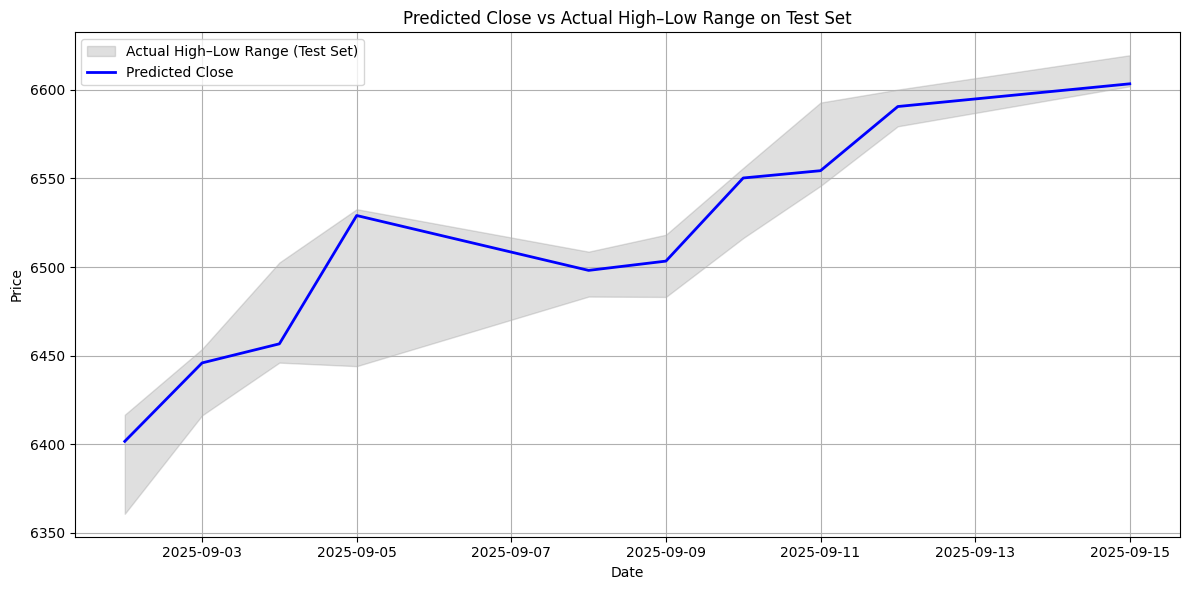

In [7]:
# Load the dataframes (assuming X_test.csv and predicted_close.csv exist)
try:
    test_df_plot = pd.read_csv("X_test.csv")
    pred_df_plot = pd.read_csv("predictions.csv")
except FileNotFoundError as e:
    print(f"Error loading file: {e}.")
    exit()

# Convert 'Date' columns to datetime objects
test_df_plot['Date'] = pd.to_datetime(test_df_plot['Date'])
pred_df_plot['Date'] = pd.to_datetime(pred_df_plot['Date'])

# Merge the dataframes based on the 'Date' column for plotting
merged_df_for_plot = pd.merge(test_df_plot, pred_df_plot, on='Date', how='left')
merged_df_for_plot.sort_values('Date', inplace=True)

# Drop rows where actual High/Low or Predicted_Close might be missing (shouldn't happen if pipelines are aligned)
# Correct the column name from 'Predicted_Close' to 'Close'
merged_df_for_plot.dropna(subset=['Low', 'High', 'Close'], inplace=True)

plt.figure(figsize=(12,6))
# Plot the actual High-Low range as a shaded area
plt.fill_between(merged_df_for_plot['Date'],
                 merged_df_for_plot['Low'],
                 merged_df_for_plot['High'],
                 color='grey', alpha=0.25, label='Actual High–Low Range (Test Set)')
# Plot the predicted Close price
# Correct the column name from 'Predicted_Close' to 'Close'
plt.plot(merged_df_for_plot['Date'], merged_df_for_plot['Close'], color='blue', linewidth=2, label='Predicted Close')

plt.title('Predicted Close vs Actual High–Low Range on Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()